In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
! pip install transformers
! pip install datasets
! pip install --upgrade tqdm
! pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-non

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_auroc

from transformers import RobertaModel, RobertaTokenizerFast

import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

In [ ]:
# gpu check
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device=='cuda')

2.2.1+cu121
True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path = '/content/drive/MyDrive/Assignment_2/'
#%cd /content/drive/MyDrive/Assignment_2/
#!unzip hateful_memes

In [ ]:
path = '/content/drive/MyDrive/Assignment_2/hateful_memes/'

In [ ]:
import pandas as pd
val_seen = pd.read_json(path+'dev_seen.jsonl',lines=True)
val_unseen= pd.read_json(path+'dev_unseen.jsonl',lines=True)
test_seen=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen=pd.read_json(path+'test_unseen.jsonl',lines=True)
df_train =pd.read_json(path+'train.jsonl',lines=True)

In [ ]:
df_train.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

In [ ]:
val_seen.label.value_counts()

label
0    253
1    247
Name: count, dtype: int64

In [ ]:
class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_file, root_dir, transform=None):
        self.annotations = pd.read_json(jsonl_file, lines=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        id = self.annotations.loc[idx, 'id']
        img_path = os.path.join(self.root_dir, self.annotations.loc[idx, 'img'])
        label = self.annotations.loc[idx, 'label']
        text = self.annotations.loc[idx, 'text']

        try:
            # Load image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply transformations
            if self.transform:
                image = self.transform(image)

            sample = {"id": id, "image": image, "label": label, "text": text}

            return sample

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None

In [ ]:
hm_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
train_jsonl = os.path.join(path, "train.jsonl")
val_seen_jsonl = os.path.join(path, "dev_seen.jsonl")
val_unseen_jsonl = os.path.join(path, "dev_unseen.jsonl")
test_seen_jsonl = os.path.join(path, "test_seen.jsonl")
test_unseen_jsonl = os.path.join(path, "test_unseen.jsonl")

In [ ]:
# Create datasets
train_dataset = HatefulMemesDataset(jsonl_file=train_jsonl, root_dir=path, transform=hm_transform)
val_seen_dataset = HatefulMemesDataset(jsonl_file=val_seen_jsonl, root_dir=path, transform=hm_transform)
val_unseen_dataset = HatefulMemesDataset(jsonl_file=val_unseen_jsonl, root_dir=path, transform=hm_transform)
test_seen_dataset = HatefulMemesDataset(jsonl_file=test_seen_jsonl, root_dir=path, transform=hm_transform)
test_unseen_dataset = HatefulMemesDataset(jsonl_file=test_unseen_jsonl, root_dir=path, transform=hm_transform)

In [ ]:
# Hyperparameters
batch_size = 64

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_seen_dataloader = DataLoader(val_seen_dataset, batch_size=batch_size, shuffle=False)
val_unseen_dataloader = DataLoader(val_unseen_dataset, batch_size=batch_size, shuffle=False)
test_seen_dataloader = DataLoader(test_seen_dataset, batch_size=batch_size, shuffle=False)
test_unseen_dataloader = DataLoader(test_unseen_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import ConcatDataset

# Combine datasets
val_dataset = ConcatDataset([val_seen_dataset, val_unseen_dataset])
# Combine data loaders
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Combine datasets
test_dataset = ConcatDataset([test_seen_dataset, test_unseen_dataset])
# Combine data loaders
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

GoogleNet

In [ ]:
# Load pre-trained GoogLeNet model
googlenet = models.googlenet(pretrained=True).to(device)

# Remove the classifier (top) layer
modules = list(googlenet.children())[:-1]
googlenet_fe = nn.Sequential(*modules)

# Freeze the parameters of the feature extraction layers
for p in googlenet_fe.parameters():
    p.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 114MB/s]


# ROBERTA

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

roberta_model.to(device)

for param in roberta_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class BaseLineHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.BatchNorm1d(1792), # test add batchnorm, b/c image and text encoding have diff ranges
            nn.Linear(1792, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 2),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [ ]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1792, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [ ]:
def get_metrics_and_losses(losses, predictions, labels):
  average_loss = losses.mean().item()
  accuracy = (predictions == labels).sum().item() / labels.numel()

  # print(predictions)
  # print(labels)
  auroc = binary_auroc(predictions, labels)

  return average_loss, accuracy, auroc

# Test on 1 Batch

In [ ]:
sample_test = next(iter(test_seen_dataloader))

torch.Size([64, 3, 256, 256])
tensor(16395)
handjobs sold seperately
tensor(1, device='cuda:0')


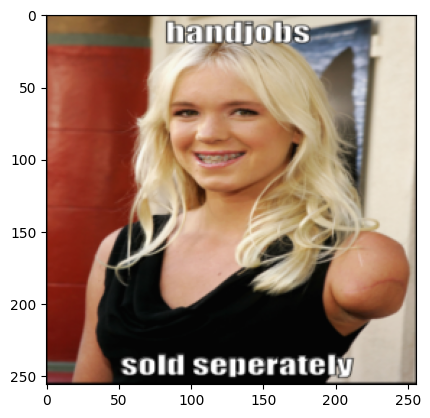

In [ ]:
text = sample_test['text']
image = sample_test['image'].to(device)
labels = sample_test['label'].to(device).to(torch.int64)

id = sample_test["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
sample_valid = next(iter(val_seen_dataloader))

torch.Size([64, 3, 256, 256])
tensor(8291)
white people is this a shooting range
tensor(1, device='cuda:0')
torch.float32


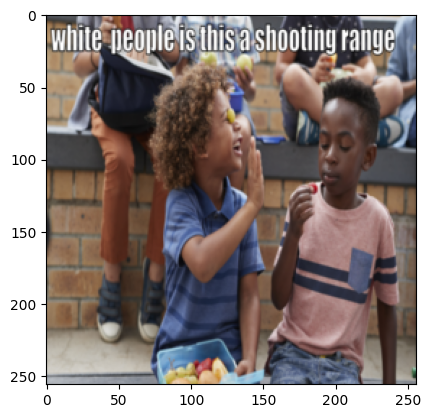

In [ ]:
text = sample_valid['text']
image = sample_valid['image'].to(device)
labels = sample_valid['label'].to(device).to(torch.int64)

id = sample_valid["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
print(image[0].dtype)

In [ ]:
image = image.float()
image_features = googlenet_fe(image).squeeze()

print(image_features.shape)
print(image_features)

print(torch.max(image_features))
print(torch.min(image_features))

torch.Size([64, 1024])
tensor([[0.0000, 0.7017, 0.0000,  ..., 0.0000, 0.2519, 0.2956],
        [1.1032, 0.6735, 0.6352,  ..., 0.7777, 0.1305, 0.0362],
        [0.6350, 1.9137, 0.9129,  ..., 0.0000, 0.3117, 0.0000],
        ...,
        [0.1179, 0.1001, 0.1756,  ..., 0.0000, 0.7820, 1.1756],
        [0.2011, 0.5595, 0.3204,  ..., 0.1365, 1.4686, 0.1673],
        [0.0947, 0.4274, 0.1101,  ..., 0.2586, 0.0470, 1.8483]],
       device='cuda:0')
tensor(3.3657, device='cuda:0')
tensor(0., device='cuda:0')


In [ ]:
sample_batch = next(iter(train_dataloader))

torch.Size([64, 3, 256, 256])
shoot them
tensor(0, device='cuda:0')
torch.float32


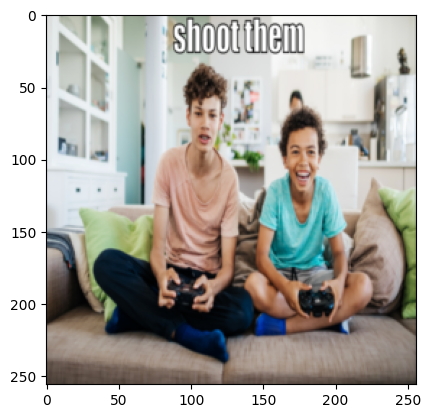

In [ ]:
# get inputs
text = sample_batch['text']
image = sample_batch['image'].to(device)
labels = sample_batch['label'].to(device).to(torch.int64)

print(image.shape)

print(text[0])
print(labels[0])

# plt.imshow(image[0].to(torch.int64).cpu().detach().numpy().transpose(1, 2, 0))
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
print(image[0].dtype)

In [ ]:
image = image.float()
image_features = googlenet_fe(image).squeeze()

print(image_features.shape)
print(image_features)

print(torch.max(image_features))
print(torch.min(image_features))

torch.Size([64, 1024])
tensor([[0.2682, 1.1108, 0.0988,  ..., 0.0000, 0.3536, 0.8209],
        [0.1866, 0.2197, 0.2679,  ..., 0.3045, 0.1129, 0.8330],
        [0.2349, 0.4303, 0.0546,  ..., 0.4788, 1.1130, 1.0913],
        ...,
        [0.1631, 0.1511, 0.2236,  ..., 0.0774, 0.1380, 0.0000],
        [0.2048, 0.5144, 0.7648,  ..., 0.0000, 0.1749, 0.1420],
        [0.3064, 0.4075, 0.3169,  ..., 1.5283, 0.2787, 0.1250]],
       device='cuda:0')
tensor(3.3683, device='cuda:0')
tensor(0., device='cuda:0')


In [ ]:
# Get Text Features

tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
text_features = roberta_model(**tokenized_input)

print(text_features["pooler_output"].shape)
print(text_features["pooler_output"])

print(torch.max(text_features["pooler_output"]))
print(torch.min(text_features["pooler_output"]))

torch.Size([64, 768])
tensor([[-0.3947,  0.1251,  0.3776,  ..., -0.1296,  0.3377,  0.0239],
        [-0.3822,  0.1340,  0.3728,  ..., -0.1496,  0.3640,  0.0457],
        [-0.3816,  0.1138,  0.3740,  ..., -0.1142,  0.3287,  0.0076],
        ...,
        [-0.3792,  0.1284,  0.3661,  ..., -0.1450,  0.3426,  0.0292],
        [-0.3949,  0.1271,  0.3806,  ..., -0.1325,  0.3551,  0.0455],
        [-0.3849,  0.1171,  0.3881,  ..., -0.1284,  0.3494,  0.0218]],
       device='cuda:0')
tensor(0.6529, device='cuda:0')
tensor(-0.6354, device='cuda:0')


In [ ]:
# concatenate both features

concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

print(concat_features.shape)
print(concat_features)

print(torch.min(concat_features))
print(torch.max(concat_features))

torch.Size([64, 1792])
tensor([[ 0.2682,  1.1108,  0.0988,  ..., -0.1296,  0.3377,  0.0239],
        [ 0.1866,  0.2197,  0.2679,  ..., -0.1496,  0.3640,  0.0457],
        [ 0.2349,  0.4303,  0.0546,  ..., -0.1142,  0.3287,  0.0076],
        ...,
        [ 0.1631,  0.1511,  0.2236,  ..., -0.1450,  0.3426,  0.0292],
        [ 0.2048,  0.5144,  0.7648,  ..., -0.1325,  0.3551,  0.0455],
        [ 0.3064,  0.4075,  0.3169,  ..., -0.1284,  0.3494,  0.0218]],
       device='cuda:0')
tensor(-0.6354, device='cuda:0')
tensor(3.3683, device='cuda:0')


In [ ]:
batchnorm = nn.BatchNorm1d(1792).to(device)

normalized_features = batchnorm(concat_features)

In [ ]:
print(normalized_features.shape)
print(normalized_features)

print(torch.min(normalized_features))
print(torch.max(normalized_features))

torch.Size([64, 1792])
tensor([[-0.3549,  2.5194, -0.8820,  ...,  0.3461, -0.7872, -0.0750],
        [-0.6133, -0.4761, -0.3650,  ..., -1.2256,  1.6018,  1.3126],
        [-0.4603,  0.2318, -1.0173,  ...,  1.5586, -1.6130, -1.1071],
        ...,
        [-0.6878, -0.7068, -0.5003,  ..., -0.8608, -0.3431,  0.2632],
        [-0.5558,  0.5145,  1.1549,  ...,  0.1170,  0.7949,  1.2951],
        [-0.2339,  0.1553, -0.2150,  ...,  0.4435,  0.2772, -0.2079]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
tensor(-5.6979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4330, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
softmax = nn.Softmax(dim=-1)

In [ ]:
scores = head(concat_features)

pred = scores.argmax(dim=-1)

print(scores)
print(pred)
print(labels)

tensor([[ 0.1772, -0.1233],
        [-0.0633,  0.0753],
        [-0.1497,  0.0118],
        [-0.1083, -0.2428],
        [-0.2720, -0.4855],
        [ 0.3259, -0.2224],
        [-0.0115, -0.2606],
        [-0.0664,  0.0203],
        [ 0.0579, -0.3153],
        [-0.0879, -0.1181],
        [-0.1679, -0.0462],
        [-0.1122, -0.3496],
        [ 0.0150, -0.1482],
        [ 0.2645, -0.2532],
        [-0.0785, -0.3278],
        [ 0.0779, -0.4470],
        [ 0.3942, -0.0751],
        [ 0.2254, -0.4133],
        [-0.1245, -0.1571],
        [ 0.0165, -0.1885],
        [ 0.0259, -0.1318],
        [-0.3071,  0.0285],
        [-0.0092,  0.0488],
        [ 0.0520, -0.0688],
        [-0.3658, -0.2268],
        [-0.0101, -0.2325],
        [ 0.6040, -0.2935],
        [ 0.2150, -0.1221],
        [ 0.0197, -0.2760],
        [ 0.0262, -0.0074],
        [ 0.0634, -0.1227],
        [ 0.0597, -0.2073],
        [ 0.0513, -0.2676],
        [ 0.0442, -0.2628],
        [-0.2148, -0.1878],
        [ 0.2208, -0

# Train Model

In [ ]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(1792, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1792, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [ ]:
lr = 1e-4
epochs = 10
weight_decay = 1e-3

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(head.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
loss = criterion(scores, labels)
print(loss)

loss, acc, auroc = get_metrics_and_losses(loss, pred, labels)

print(loss)
print(acc)
print(auroc)

tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward0>)
0.6492480635643005
0.65625
tensor(0.5731, device='cuda:0', dtype=torch.float64)


# Training Loop

In [ ]:
model_path ='/content/drive/MyDrive/Assignment_2/hateful_memes/'

In [ ]:
!mkdir -p models

In [ ]:
# train model head
max_validation_auroc = 0

for e in range(epochs):

  # training
  train_losses = torch.zeros(len(train_dataloader)).to(device)
  train_predictions = torch.Tensor().to(device)
  train_labels = torch.Tensor().to(device)

  googlenet_fe.train()
  roberta_model.train()
  head.train()

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(e+1) + " Training"):

    # get inputs
    text = data['text']
    image = data['image'].to(device).float()
    labels = data['label'].to(device).to(torch.int64)

    # zero the parameter gradients
    optimizer.zero_grad()


    # GoogleNet Image Features
    image_features = googlenet_fe(image).squeeze()

    # BERT Text Features
    tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
    text_features = roberta_model(**tokenized_input)

    # print("after-BERT")

    # Concatenate Features
    concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

    # print("pre-head")

    # classification head
    scores = torch.squeeze(head(concat_features))
    predictions = scores.argmax(dim=-1)

    # print("after-head")
    # print("pre-backprop")

    # backprop
    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()

    # print("after-backprop")

    # track values for metric logging
    train_losses[i] = loss
    train_predictions = torch.cat((train_predictions, predictions))
    train_labels = torch.cat((train_labels, labels))

    train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(train_losses, train_predictions, train_labels)

  # validation
  validate_losses = torch.zeros(len(val_dataloader)).to(device)
  validate_predictions = torch.Tensor().to(device)
  validate_labels = torch.Tensor().to(device)

  googlenet_fe.eval()
  roberta_model.eval()
  head.eval()

  with torch.no_grad():
    for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Epoch " + str(e+1) + " Validation"):

      # get inputs
      # get inputs
      text = data['text']
      image = data['image'].to(device).float()
      labels = data['label'].to(device).to(torch.int64)

      # GoogleNet Image Features
      image_features = googlenet_fe(image).squeeze()

      # BERT Text Features
      tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
      text_features = roberta_model(**tokenized_input)

      # Concatenate Features
      concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

      # classification head
      scores = torch.squeeze(head(concat_features))
      predictions = scores.argmax(dim=-1)

      # loss
      loss = criterion(scores, labels)

      # track values for metric logging
      validate_losses[i] = loss
      validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
      validate_labels = torch.cat((validate_labels, labels), dim=0)

  validate_average_loss, validate_accuracy, validate_auroc = get_metrics_and_losses(validate_losses, validate_predictions, validate_labels)

  # save model
  if validate_auroc > max_validation_auroc:
    max_validation_auroc = validate_auroc
    torch.save(head, model_path +"/concat_roberta_" + str(e+1) + ".pt")
    print("New model saved at epoch " + str(e+1))

  print(train_predictions[:64])
  print(train_labels[:64])
  print(validate_predictions[:64])
  print(validate_labels[:64])

  print("Epoch %d" % (e+1))
  print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_average_loss, validate_average_loss))
  print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, validate_accuracy))
  print("Training AUROC: %.4f. Validation AUROC: %.4f. " % (train_auroc, validate_auroc))
  print("-----------------------------------")

torch.save(head, model_path +"/concat_roberta_final" + ".pt")
  # looks promising on training - failing to generalize = overfitting
  # add batchnorm (done)
  # inc dropout (done)
  # remove middle layer (not much effect - try reducing hidden size)
  # add weight decay - essentialy explicit L2 regularization -> **best results so far**
  # implement early stopping
  # incr to 20 epochs? -> 40 mins to train...

  # try without sigmoid - maybe better

Epoch 1 Training:  41%|████▏     | 55/133 [19:47<28:04, 21.59s/it]


KeyboardInterrupt: 

In [ ]:
# Rebuild the model architecture
best_head = torch.load(model_path + "/concat_roberta_1.pt")
best_head.to(device)

# Load the saved head weights
# best_head.load_state_dict(torch.load(model_path + "/concat_roberta_best.pt"))

# Evaluate on test set
test_losses = torch.zeros(len(test_dataloader)).to(device)
test_predictions = torch.Tensor().to(device)
test_labels = torch.Tensor().to(device)

best_head.eval()  # Set the head to evaluation mode

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Testing"):
        text = data['text']
        image = data['image'].to(device).float()
        labels = data['label'].to(device).to(torch.int64)

        image_features = googlenet_fe(image).squeeze()

        tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
        text_features = roberta_model(**tokenized_input)

        concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

        scores = torch.squeeze(best_head(concat_features))
        predictions = scores.argmax(dim=-1)

        loss = criterion(scores, labels)

        test_losses[i] = loss
        test_predictions = torch.cat((test_predictions, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

test_average_loss, test_accuracy, test_auroc = get_metrics_and_losses(test_losses, test_predictions, test_labels)

print("Test Loss: %.4f" % test_average_loss)
print("Test Accuracy: %.4f" % test_accuracy)
print("Test AUROC: %.4f" % test_auroc)

Testing: 100%|██████████| 47/47 [01:06<00:00,  1.41s/it]

Test Loss: 1.2756
Test Accuracy: 0.5867
Test AUROC: 0.5000
